<h4 style="background-color: #80c4e6; display: flex; padding: 0.5em; color: #000;">
    NASA Breath Diagnosmtics Challenge
</h4>

##### 1 - Data Exploration and Preparation

In [150]:
# general setup
import os, glob, sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# model setup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

# utils setup
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
sys.path.append(root_directory)

# custom utils
from utils.io import ENoseIO
from utils.visu import VISU

In [151]:
max_length  = 378
num_sensors = 64

##### 2 - Read and Load Data

In [152]:
train_files = glob.glob('../dataset/train/*.txt')
test_files  = glob.glob('../dataset/test/*.txt')
train_data  = pd.concat([ENoseIO.read_patient_data(f) for f in train_files])
test_data   = pd.concat([ENoseIO.read_patient_data(f, is_labeled=False) for f in test_files])

##### 3 - Read and Format training label

In [153]:
# Train data
y_train_label= []
for f in train_files:
    Feature = ENoseIO.read_patient_data(f)
    label = Feature['Result'].iloc[0]
    y_train_label.append(label)
y_train_label = np.array(y_train_label)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_label)


In [154]:
train_data

,Min:Sec,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D57,D58,D59,D60,D61,D62,D63,D64,Patient_ID,Result
0,07:29.6,9934.068034,1493.775934,695.734215,1274.504328,10810.90837,1501.151543,57410.52632,2011158.375,710.478301,...,836.833188,12150.26004,302148.8224,23528.25517,22332.09609,18073.57374,108110.7166,770474.7984,21,POSITIVE
1,07:31.8,9938.208689,1493.775934,696.158250,1274.903259,10836.83381,1501.704284,57422.80702,2014549.041,711.651245,...,838.245110,12148.76342,302083.1378,23550.83018,22341.90069,18060.17640,108148.6333,770639.8227,21,POSITIVE
2,07:34.1,9935.979106,1488.842785,695.204173,1260.461962,10768.57443,1495.808383,57307.01754,1984772.825,711.694687,...,835.575294,12151.75665,302186.3564,23503.49548,22206.03684,18074.13196,108079.6939,769909.0009,21,POSITIVE
3,07:36.4,9922.283093,1482.803135,692.829581,1249.132325,10680.29667,1483.417780,56922.80702,1937919.980,700.073852,...,834.728141,12138.66128,302270.8079,23487.47451,22190.62960,18056.82706,107941.8152,769060.3046,21,POSITIVE
4,07:38.6,9922.920117,1481.097280,691.833100,1242.071249,10672.42058,1478.949793,56750.87719,1918192.467,694.534949,...,834.137701,12147.26681,302120.6719,23471.45354,22370.61419,18051.80306,107907.3455,768824.5556,21,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,15:14.0,10048.343660,1499.674085,816.511726,1268.171431,12080.84824,1517.008055,58212.28070,2160574.580,724.148115,...,835.951591,12190.64047,312401.5174,25000.00000,23329.27386,18766.31010,108586.1960,779580.6169,38,POSITIVE
372,15:16.3,10048.668120,1499.580967,816.223292,1267.650243,11984.75812,1516.639816,58203.50877,2160061.562,723.489323,...,836.212981,12205.26474,312343.1573,24986.75600,23286.64941,18739.86129,108547.5194,779191.3983,38,POSITIVE
373,15:18.5,10048.668120,1499.394729,815.934858,1268.011065,12166.99801,1516.179517,58203.50877,2160831.089,723.875511,...,835.794756,12219.51402,312294.5239,24986.75600,23317.09545,18754.55507,108533.4552,778996.7889,38,POSITIVE
374,15:20.8,10052.561570,1499.627526,815.823922,1267.690334,11905.23526,1516.962025,58212.28070,2161921.252,723.966379,...,835.951591,12201.13994,312255.6172,24981.30259,23167.14873,18748.08981,108508.8429,779094.0936,38,POSITIVE


##### 4 - Normalisation of features

In [155]:
X_train = train_data.drop(columns=['Min:Sec', 'Result', 'Patient_ID'])
X_test = test_data.drop(columns=['Min:Sec', 'Patient_ID'])

# Select col
best_col = [' D64', ' D21', ' D62', ' D5', ' D63', ' D22', ' D52', ' D60']
X_train = X_train[best_col]
X_test = X_test[best_col]

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_train_scaled = X_train
X_test_scaled  = scaler.transform(X_test)
#X_test_scaled  = X_test

In [156]:
num_col = 8
X_train_standardized = np.zeros((45, 378, num_col))
for p,i in enumerate(range(0, X_train_scaled.shape[0]-378, 378)):
    X_train_standardized[p] = X_train_scaled[i:i+378]

X_train_standardized.shape

(45, 378, 8)

In [157]:
X_test_standardized = np.zeros((18, 378, num_col))
for p,i in enumerate(range(0, X_test_scaled.shape[0]-378, 378)):
    X_test_standardized[p] = X_test_scaled[i:i+378]

X_test_standardized.shape

(18, 378, 8)

##### 5 - Model Training

In [158]:
model = Sequential([
    Input(shape=(max_length, num_col)),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [159]:
history = model.fit(X_train_standardized, y_train_encoded, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.3308 - loss: 0.7161
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5370 - loss: 0.6785
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6440 - loss: 0.6454
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6528 - loss: 0.6264
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7285 - loss: 0.5971
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6884 - loss: 0.5716
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7537 - loss: 0.5400
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8042 - loss: 0.5140
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7641 - loss: 0.4693
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7745 - loss: 0.4425
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7937 - loss: 0.4456
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7581 - loss: 0.4612
E

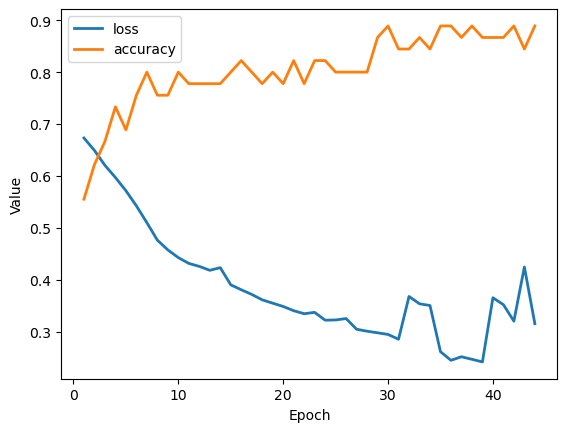

In [160]:
VISU.plot_curve(history, ['loss', 'accuracy'])

##### 6 - Model Evaluation

##### 7 - Prediction for ctf submission

In [164]:
y_test_proba = model.predict(X_test_standardized)
y_test_pred_ = []
for prob in y_test_proba:
    y_test_pred_.append(1 if prob[0] >= 0.5 else 0)
y_test_pred_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


[1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1]

* **Save results**

In [165]:
ENoseIO.save_predictions_to_csv(y_test_pred_)

Saved predictions to submissions/submission_4.csv
